# <center>MNB - Multinomial Naive Bayes</center>


In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import Ridge
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from helpers import global_classification_report,printmd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/data.csv')

In [2]:
print('Shape before',df.shape)
df = df.dropna(subset = ['text'])
print('Shape',df.shape)
df.head()

Shape before (1308, 27)
Shape (1177, 27)


Unnamed: 0.1  Unnamed: 0         filename  \
0             0           0  img_0000000.jpg   
1             1           1  img_0000001.jpg   
2             2           2  img_0000002.jpg   
3             3           3  img_0000003.jpg   
4             4           4  img_0000004.jpg   

                                                 url  \
0  https://templates.invoicehome.com/modele-factu...   
1  https://templates.invoicehome.com/modele-factu...   
2  https://www.coover.fr/wp-content/uploads/2021/...   
3  https://templates.invoicehome.com/modele-factu...   
4  https://files.intum.com/v/vosfactures/files/31...   

                                         description     type  \
0  100 modèles gratuits de factures | Téléchargem...  facture   
1  100 modèles gratuits de factures | Téléchargem...  facture   
2  Facture proforma : modèle à télécharger gratui...  facture   
3  100 modèles gratuits de factures | Téléchargem...  facture   
4  Base de Connaissances - Vos Factures - Créer u...  facture   

                  filepath  scraped     old_filename  \
0  ./final/img_0000000.jpg        1  img_0000000.jpg   
1  ./final/img_0000001.jpg        1  img_0000001.jpg   
2  ./final/img_0000002.jpg        1  img_0000002.jpg   
3  ./final/img_0000003.jpg        1  img_0000003.jpg   
4  ./final/img_0000004.jpg        1  img_0000004.jpg   

                old_filepath  ...  \
0  ./facture/img_0000000.jpg  ...   
1  ./facture/img_0000001.jpg  ...   
2  ./facture/img_0000002.jpg  ...   
3  ./facture/img_0000003.jpg  ...   
4  ./facture/img_0000004.jpg  ...   

                                            text_ocr  words_count  \
0   FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...           98   
1   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           97   
2   FACTURE Mon entreprise : Nom de la société Ad...           45   
3   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           99   
4   Payer en ligne > FACTURE No SFIDELI F/05.2020...          157   

                                             text_en  \
0  Invoice Logo Joanna Binet Coubertin Paris Invo...   
1  Joanna Binet Coubertin Paris Invoice Invoice i...   
2  Invoice My company : Company name Mail address...   
3  Joanna Binet Coubertin Paris Bill To Cinderell...   
4  Pay online Invoice No Sfideli F/ Creation date...   

                                             text_fr  \
0   Facture Logo Joanna Binet  Coubertin  Paris F...   
1   Joanna Binet  Coubertin  Paris Facture Factur...   
2   Facture Mon entreprise : Nom de la société Ad...   
3   Joanna Binet  Coubertin  Paris Facture À Cend...   
4   Payer en ligne  Facture No Sfideli F/ Date de...   

                                        text_fr_norm  \
0  facture logo joanna binet coubertin paris fact...   
1  joanna binet coubertin paris facture facturé c...   
2  facture entreprise société adresse postale adr...   
3  joanna binet coubertin paris facture cendrillo...   
4  payer ligne facture sfideli date création date...   

                                        text_en_norm  target_en target_fr  \
0  invoice logo joanna binet coubertin paris invo...    invoice   facture   
1  joanna binet coubertin paris invoice invoice c...    invoice   facture   
2  invoice company company name mail address tele...    invoice   facture   
3  joanna binet coubertin paris bill cinderella a...    invoice   facture   
4  online invoice sfideli creation date validity ...    invoice   facture   

    target target_min  
0  invoice    invoice  
1  invoice    invoice  
2  invoice    invoice  
3  invoice    invoice  
4  invoice    invoice  

[5 rows x 27 columns]

**Test SVM multiple combinations**

In [3]:
TARGETS = ['target','target_min']
DATA = ['text_en_norm','text_fr_norm','text']
OVERSAMPLER = ['none','ros']


**SVC model trained with a GridSearch**

In [13]:
def MNB_collect_stats(df,data,target,oversampler):
    df = df.dropna(subset = [data])
    print('Parameters:',data,target,oversampler, 'Shape:',df.shape[0])
    
    labels = ['classic']
    labels.append(target)
    X = df[data]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1234)
    if (data=='text_en_norm'):
        labels.append('english')
    if (data=='text_fr_norm'):
        labels.append('french')
 

    vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', lowercase=True,min_df=5, max_df=0.7)
    
    mnb = MultinomialNB(alpha=0.1)
    param_grid = [{'multinomialnb__alpha': np.logspace(-3, 0, 4) }]
    
    if (oversampler=='ros'):
        ros = RandomOverSampler()
        p1 = make_pipeline(vectorizer,ros, mnb)
        labels.append(oversampler)
    elif (oversampler=='smote'):
        smote = SMOTE(k_neighbors=1)
        p1 = make_pipeline(vectorizer,smote, mnb)
        labels.append(oversampler)
    else:
        p1 = make_pipeline(vectorizer, mnb)
    

    gs = GridSearchCV(p1, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    print('Classification report on',' '.join(labels))
    global_classification_report(y_test, y_pred,classifier="MNB",category=' '.join(labels))
    return (y_test,y_pred)
    
for t in TARGETS:
    for d in DATA:
        for o in OVERSAMPLER:
            df = pd.read_csv('../data/data.csv')
            MNB_collect_stats(df,d,t,o)



Parameters: text_en_norm target none Shape: 1051


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target english
                        precision    recall  f1-score   support

         advertisement       1.00      0.40      0.57         5
                budget       1.00      0.12      0.22         8
                 email       0.75      1.00      0.86         3
           file folder       0.00      0.00      0.00         1
                  form       0.33      0.20      0.25         5
           handwritten       0.50      0.20      0.29         5
              id piece       0.85      1.00      0.92        23
               invoice       0.62      0.89      0.73        18
                letter       0.67      0.20      0.31        10
                  memo       0.80      0.67      0.73         6
          news article       0.14      0.25      0.18         4
              passport       1.00      0.62      0.76        13
                   pay       0.72      0.96      0.82        45
              postcard       0.67      0.53      0.59  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Classification report on classic target english ros
                        precision    recall  f1-score   support

         advertisement       0.13      0.60      0.21         5
                budget       0.44      0.50      0.47         8
                 email       0.75      1.00      0.86         3
           file folder       0.00      0.00      0.00         1
                  form       0.14      0.20      0.17         5
           handwritten       0.50      0.20      0.29         5
              id piece       0.96      1.00      0.98        23
               invoice       0.68      0.83      0.75        18
                letter       0.50      0.30      0.37        10
                  memo       0.50      0.33      0.40         6
          news article       0.14      0.25      0.18         4
              passport       1.00      0.85      0.92        13
                   pay       1.00      0.87      0.93        45
              postcard       0.72      0.43      0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Classification report on classic target french
                        precision    recall  f1-score   support

         advertisement       0.50      0.20      0.29         5
                budget       0.75      0.30      0.43        10
                 email       0.40      0.40      0.40         5
                  form       0.00      0.00      0.00         2
           handwritten       1.00      0.29      0.44         7
              id piece       0.88      1.00      0.94        23
               invoice       0.78      0.88      0.82        16
                letter       0.36      0.50      0.42         8
                  memo       0.88      0.78      0.82         9
          news article       0.17      0.25      0.20         4
              passport       0.73      0.62      0.67        13
                   pay       0.61      1.00      0.76        41
              postcard       0.92      0.38      0.54        29
          presentation       0.20      0.33      0.25   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Classification report on classic target french ros
                        precision    recall  f1-score   support

         advertisement       0.13      0.80      0.22         5
                budget       0.67      0.40      0.50        10
                 email       0.25      0.20      0.22         5
           file folder       0.00      0.00      0.00         0
                  form       0.00      0.00      0.00         2
           handwritten       1.00      0.29      0.44         7
              id piece       0.88      1.00      0.94        23
               invoice       0.88      0.88      0.88        16
                letter       0.40      0.50      0.44         8
                  memo       0.78      0.78      0.78         9
          news article       0.18      0.50      0.27         4
              passport       0.89      0.62      0.73        13
                   pay       1.00      0.93      0.96        41
              postcard       1.00      0.31      0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Classification report on classic target
                        precision    recall  f1-score   support

         advertisement       0.60      0.75      0.67         4
                budget       0.20      0.20      0.20         5
                 email       0.62      0.83      0.71         6
                  form       1.00      0.80      0.89         5
           handwritten       1.00      0.12      0.22         8
              id piece       0.89      0.86      0.88        29
               invoice       0.72      0.81      0.76        16
                letter       0.57      0.44      0.50         9
                  memo       0.38      0.38      0.38         8
          news article       0.62      0.83      0.71         6
              passport       0.77      0.56      0.65        18
                   pay       0.71      1.00      0.83        48
              postcard       0.84      0.57      0.68        28
          presentation       0.50      0.20      0.29         5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target ros
                        precision    recall  f1-score   support

         advertisement       0.14      1.00      0.24         4
                budget       0.14      0.20      0.17         5
                 email       0.67      0.67      0.67         6
           file folder       0.00      0.00      0.00         0
                  form       0.80      0.80      0.80         5
           handwritten       1.00      0.25      0.40         8
              id piece       0.89      0.83      0.86        29
               invoice       0.80      0.50      0.62        16
                letter       0.36      0.44      0.40         9
                  memo       0.25      0.25      0.25         8
          news article       0.50      0.83      0.62         6
              passport       0.85      0.61      0.71        18
                   pay       0.98      0.85      0.91        48
              postcard       1.00      0.57      0.73      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Classification report on classic target_min english
                 precision    recall  f1-score   support

         budget       1.00      0.12      0.22         8
          email       1.00      0.33      0.50         3
    file folder       0.00      0.00      0.00         1
       id piece       0.85      1.00      0.92        23
        invoice       0.68      0.83      0.75        18
    other_types       0.67      0.76      0.71        37
       passport       1.00      0.62      0.76        13
            pay       0.72      0.96      0.82        45
       postcard       0.73      0.53      0.62        30
  questionnaire       1.00      0.83      0.91         6
residence proof       1.00      0.44      0.62         9
         resume       0.80      1.00      0.89         4
 scientific_doc       0.54      0.58      0.56        12
  specification       1.00      0.50      0.67         2

       accuracy                           0.74       211
      macro avg       0.78      0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Classification report on classic target_min english ros
                 precision    recall  f1-score   support

         budget       0.14      0.50      0.22         8
          email       0.50      0.33      0.40         3
    file folder       0.00      0.00      0.00         1
       id piece       0.92      1.00      0.96        23
        invoice       0.67      0.78      0.72        18
    other_types       0.76      0.59      0.67        37
       passport       1.00      0.77      0.87        13
            pay       1.00      0.87      0.93        45
       postcard       0.75      0.50      0.60        30
  questionnaire       0.62      0.83      0.71         6
residence proof       0.83      0.56      0.67         9
         resume       0.80      1.00      0.89         4
 scientific_doc       0.50      0.67      0.57        12
  specification       1.00      1.00      1.00         2

       accuracy                           0.72       211
      macro avg       0.68    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Classification report on classic target_min french
                 precision    recall  f1-score   support

         budget       0.75      0.30      0.43        10
          email       0.00      0.00      0.00         5
       id piece       0.88      1.00      0.94        23
        invoice       0.78      0.88      0.82        16
    other_types       0.53      0.59      0.56        34
       passport       0.89      0.62      0.73        13
            pay       0.61      1.00      0.76        41
       postcard       0.92      0.38      0.54        29
  questionnaire       0.75      0.50      0.60         6
residence proof       1.00      0.89      0.94         9
         resume       0.67      0.80      0.73         5
 scientific_doc       0.57      0.47      0.52        17
  specification       0.75      0.75      0.75         4

       accuracy                           0.69       212
      macro avg       0.70      0.63      0.64       212
   weighted avg       0.71      0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target_min french ros
                 precision    recall  f1-score   support

         budget       0.14      0.50      0.22        10
          email       0.20      0.20      0.20         5
       id piece       0.88      1.00      0.94        23
        invoice       0.82      0.88      0.85        16
    other_types       0.58      0.41      0.48        34
       passport       0.80      0.62      0.70        13
            pay       0.97      0.93      0.95        41
       postcard       1.00      0.31      0.47        29
  questionnaire       0.38      0.50      0.43         6
residence proof       1.00      0.89      0.94         9
         resume       0.67      0.80      0.73         5
 scientific_doc       0.63      0.71      0.67        17
  specification       0.60      0.75      0.67         4

       accuracy                           0.67       212
      macro avg       0.67      0.65      0.63       212
   weighted avg       0.77     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target_min
                 precision    recall  f1-score   support

         budget       0.33      0.20      0.25         5
          email       1.00      0.33      0.50         6
       id piece       0.89      0.86      0.88        29
        invoice       0.90      0.56      0.69        16
    other_types       0.62      0.82      0.70        39
       passport       0.91      0.56      0.69        18
            pay       0.72      1.00      0.83        48
       postcard       0.94      0.54      0.68        28
  questionnaire       0.86      0.86      0.86         7
residence proof       0.88      0.78      0.82         9
         resume       1.00      1.00      1.00         4
 scientific_doc       0.58      0.67      0.62        21
  specification       1.00      0.67      0.80         6

       accuracy                           0.75       236
      macro avg       0.82      0.68      0.72       236
   weighted avg       0.78      0.75      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target_min ros
                 precision    recall  f1-score   support

         budget       0.03      0.20      0.06         5
          email       0.33      0.67      0.44         6
    file folder       0.00      0.00      0.00         0
       id piece       0.89      0.86      0.88        29
        invoice       0.90      0.56      0.69        16
    other_types       0.65      0.56      0.60        39
       passport       0.79      0.61      0.69        18
            pay       0.98      0.83      0.90        48
       postcard       1.00      0.57      0.73        28
  questionnaire       0.67      0.86      0.75         7
residence proof       0.88      0.78      0.82         9
         resume       1.00      1.00      1.00         4
 scientific_doc       0.61      0.67      0.64        21
  specification       0.83      0.83      0.83         6

       accuracy                           0.69       236
      macro avg       0.68      0.64  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

### Dataviz on results

In [14]:
df_cr = pd.read_csv('../data/classification_report.csv')
df_cr = df_cr[df_cr['classifier']=='MNB']
df_cr[df_cr['index']=='accuracy'].head(30)

index  precision    recall  f1-score   support classifier  \
265  accuracy   0.677725  0.677725  0.677725  0.677725        MNB   
289  accuracy   0.654028  0.654028  0.654028  0.654028        MNB   
312  accuracy   0.655660  0.655660  0.655660  0.655660        MNB   
336  accuracy   0.660377  0.660377  0.660377  0.660377        MNB   
359  accuracy   0.716102  0.716102  0.716102  0.716102        MNB   
383  accuracy   0.673729  0.673729  0.673729  0.673729        MNB   
400  accuracy   0.739336  0.739336  0.739336  0.739336        MNB   
417  accuracy   0.720379  0.720379  0.720379  0.720379        MNB   
433  accuracy   0.688679  0.688679  0.688679  0.688679        MNB   
449  accuracy   0.669811  0.669811  0.669811  0.669811        MNB   
465  accuracy   0.750000  0.750000  0.750000  0.750000        MNB   
482  accuracy   0.694915  0.694915  0.694915  0.694915        MNB   

                           category  
265          classic target english  
289      classic target english ros  
312           classic target french  
336       classic target french ros  
359                  classic target  
383              classic target ros  
400      classic target_min english  
417  classic target_min english ros  
433       classic target_min french  
449   classic target_min french ros  
465              classic target_min  
482          classic target_min ros

**Accuracy**

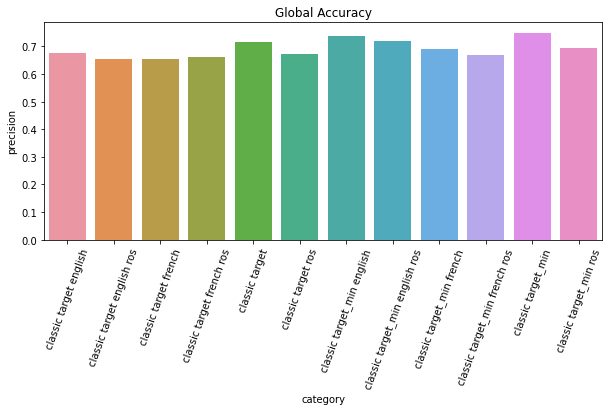

In [15]:
plt.figure(figsize=(10,4))
sns.barplot(x = 'category',y = 'precision', data = df_cr[df_cr['index']=='accuracy']).set(title='Global Accuracy')
plt.xticks(rotation=70)
plt.show()

**Passport**

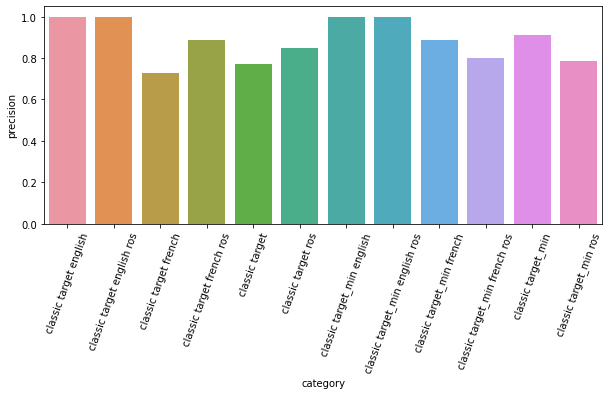

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(x = 'category',y = 'precision', data = df_cr[df_cr['index']=='passport'])
plt.xticks(rotation=70)
plt.show()

**ID piece**

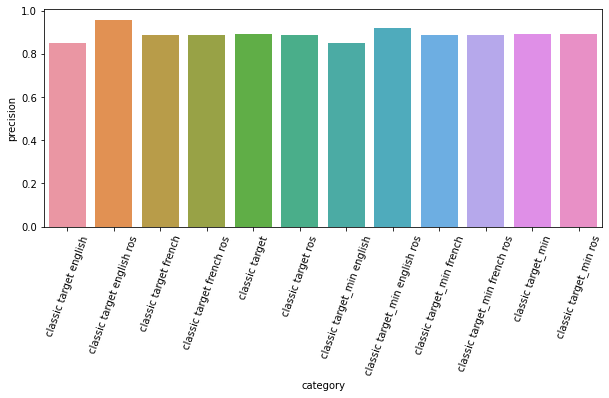

In [17]:
plt.figure(figsize=(10,4))
sns.barplot(x = 'category',y = 'precision', data = df_cr[df_cr['index']=='id piece'])
plt.xticks(rotation=70)
plt.show()

**Confusion matrix**

Parameters: text target_min none Shape: 1177


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Classification report on classic target_min
                 precision    recall  f1-score   support

         budget       0.33      0.20      0.25         5
          email       1.00      0.33      0.50         6
       id piece       0.89      0.86      0.88        29
        invoice       0.90      0.56      0.69        16
    other_types       0.62      0.82      0.70        39
       passport       0.91      0.56      0.69        18
            pay       0.72      1.00      0.83        48
       postcard       0.94      0.54      0.68        28
  questionnaire       0.86      0.86      0.86         7
residence proof       0.88      0.78      0.82         9
         resume       1.00      1.00      1.00         4
 scientific_doc       0.58      0.67      0.62        21
  specification       1.00      0.67      0.80         6

       accuracy                           0.75       236
      macro avg       0.82      0.68      0.72       236
   weighted avg       0.78      0.75      

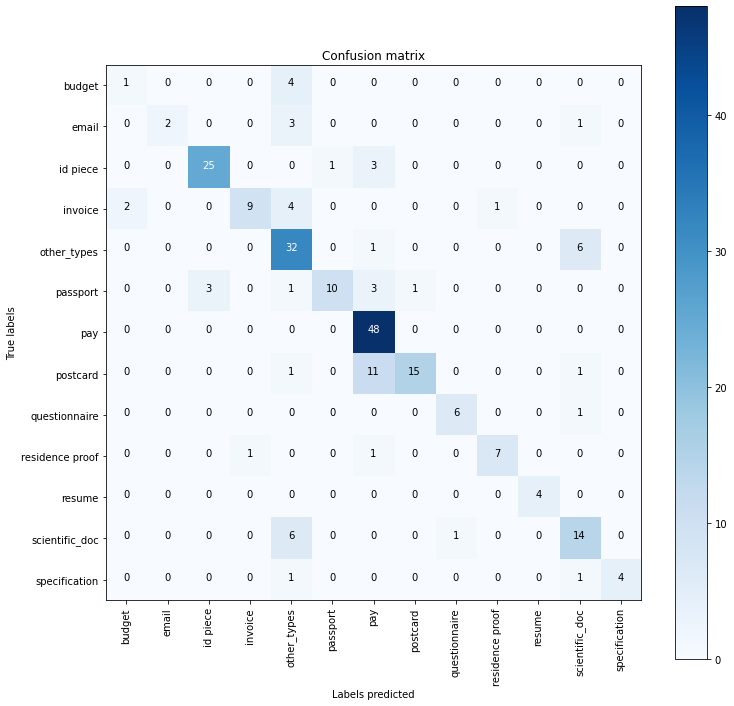

In [18]:
from helpers import confusion_matrix
f = pd.read_csv('../data/data.csv')
(y_test,y_pred) = MNB_collect_stats(df,'text','target_min','none')
confusion_matrix(y_test,y_pred)

In [19]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
 }

<IPython.core.display.Javascript object>

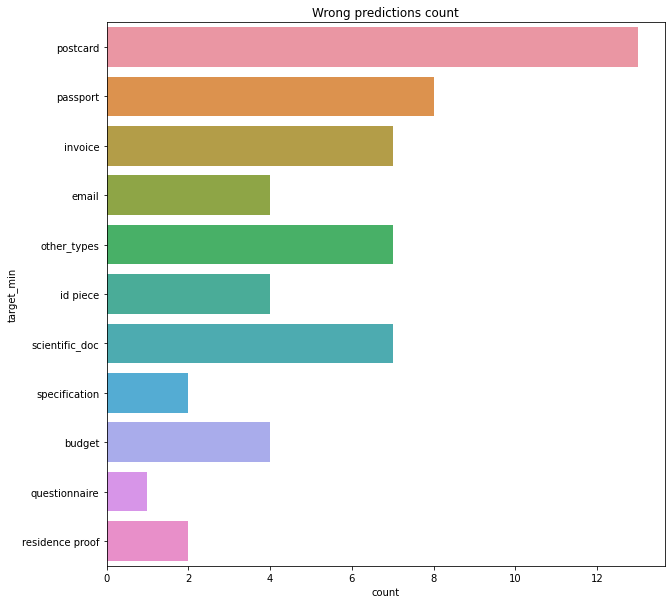

## Wrong predictions for postcard

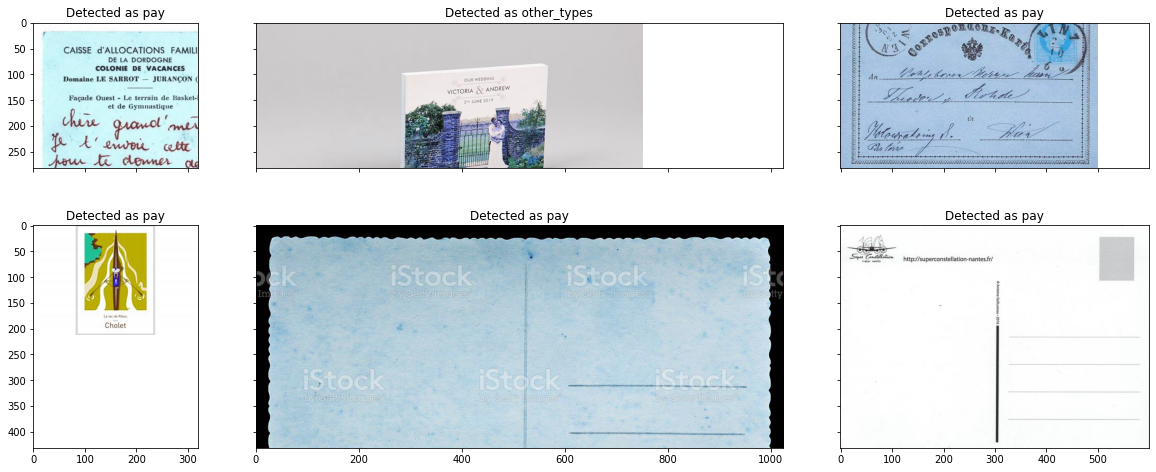

## Wrong predictions for passport

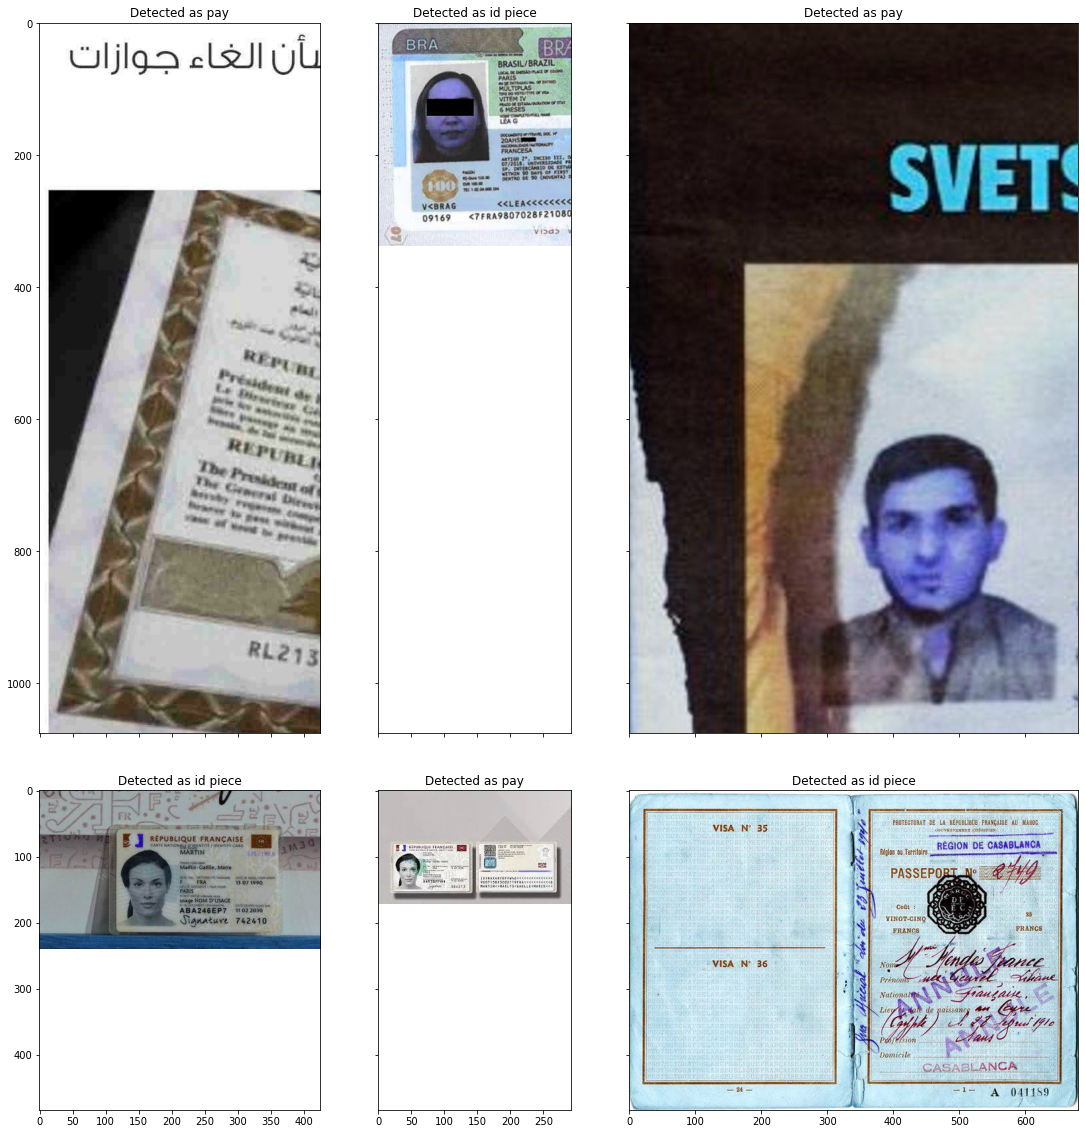

## Wrong predictions for invoice

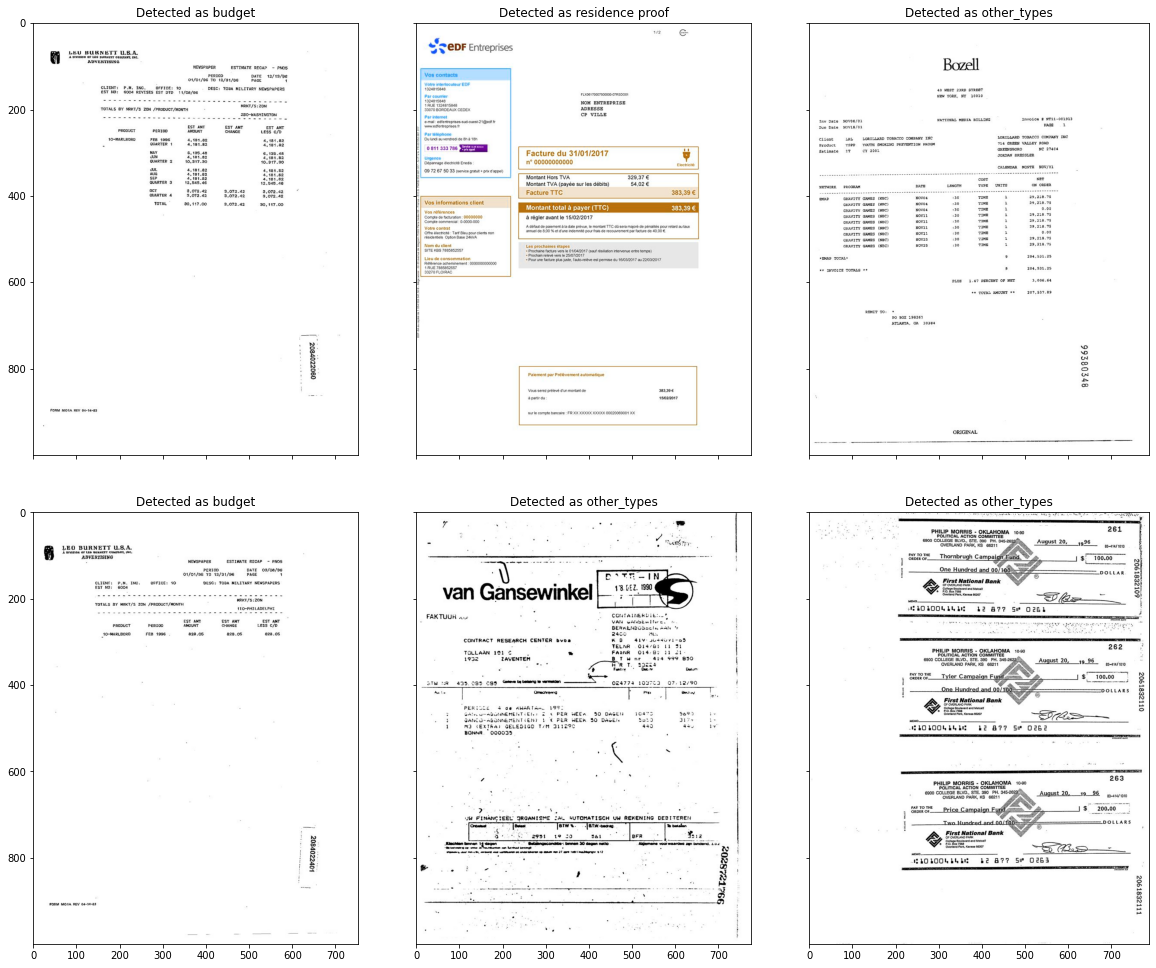

## Wrong predictions for other_types

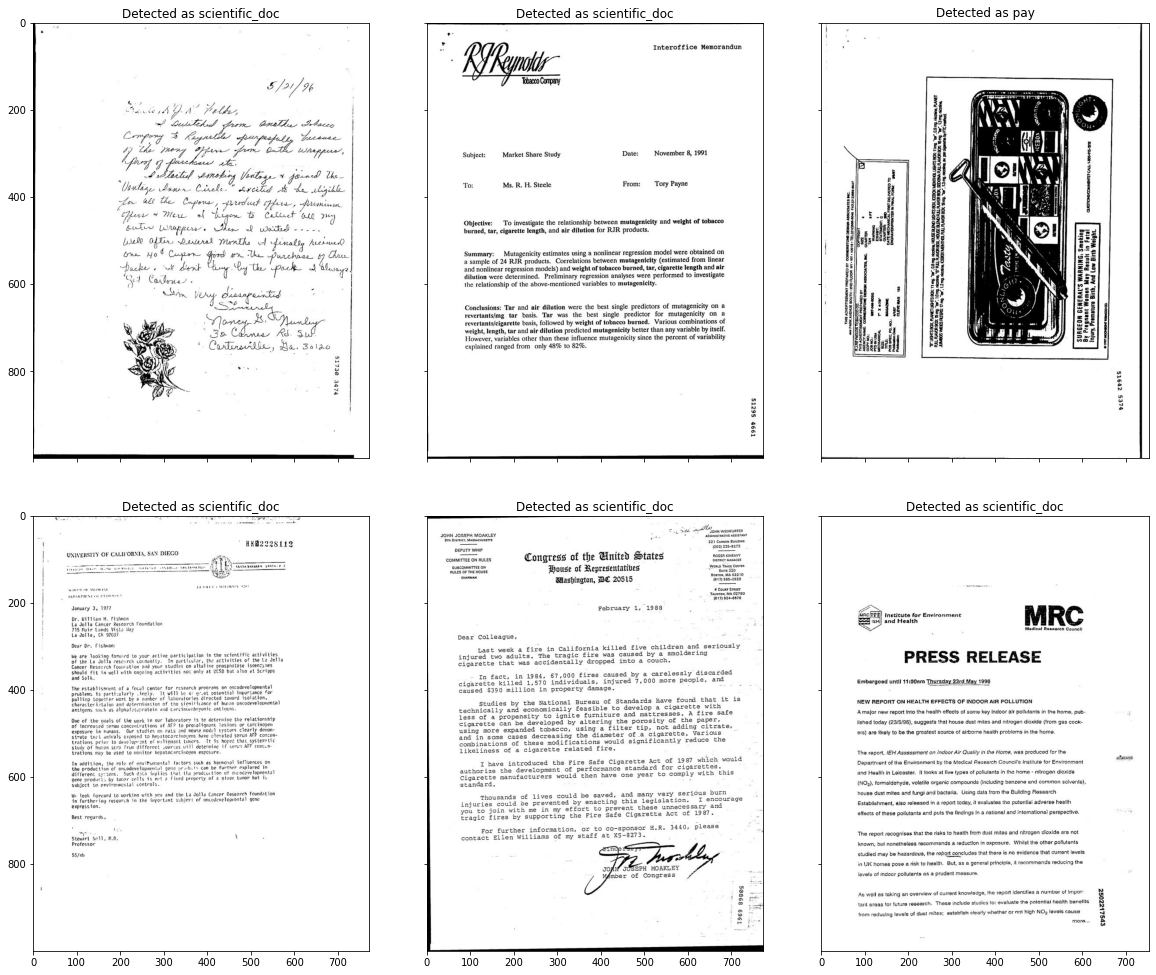

## Wrong predictions for scientific_doc

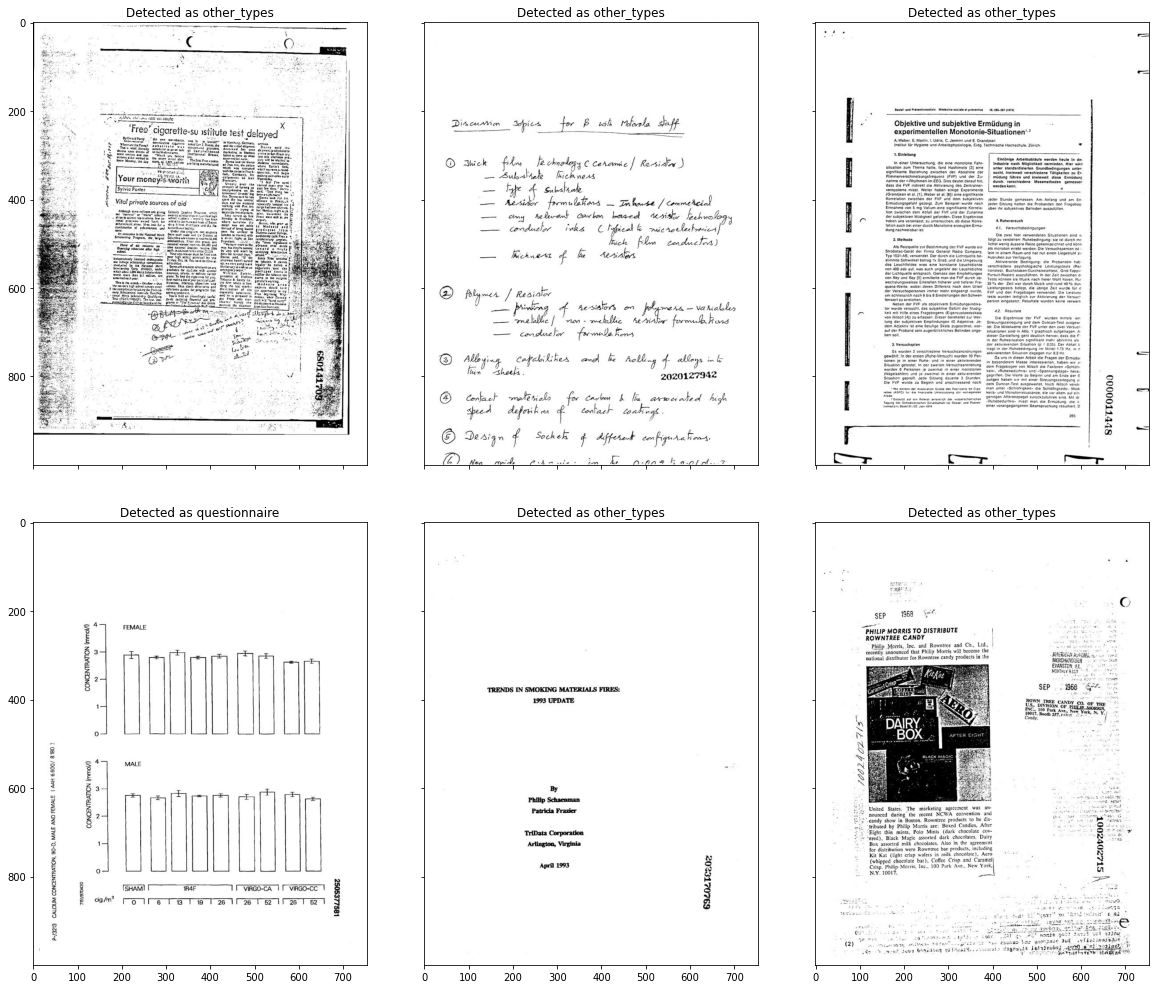

## Wrong predictions for email

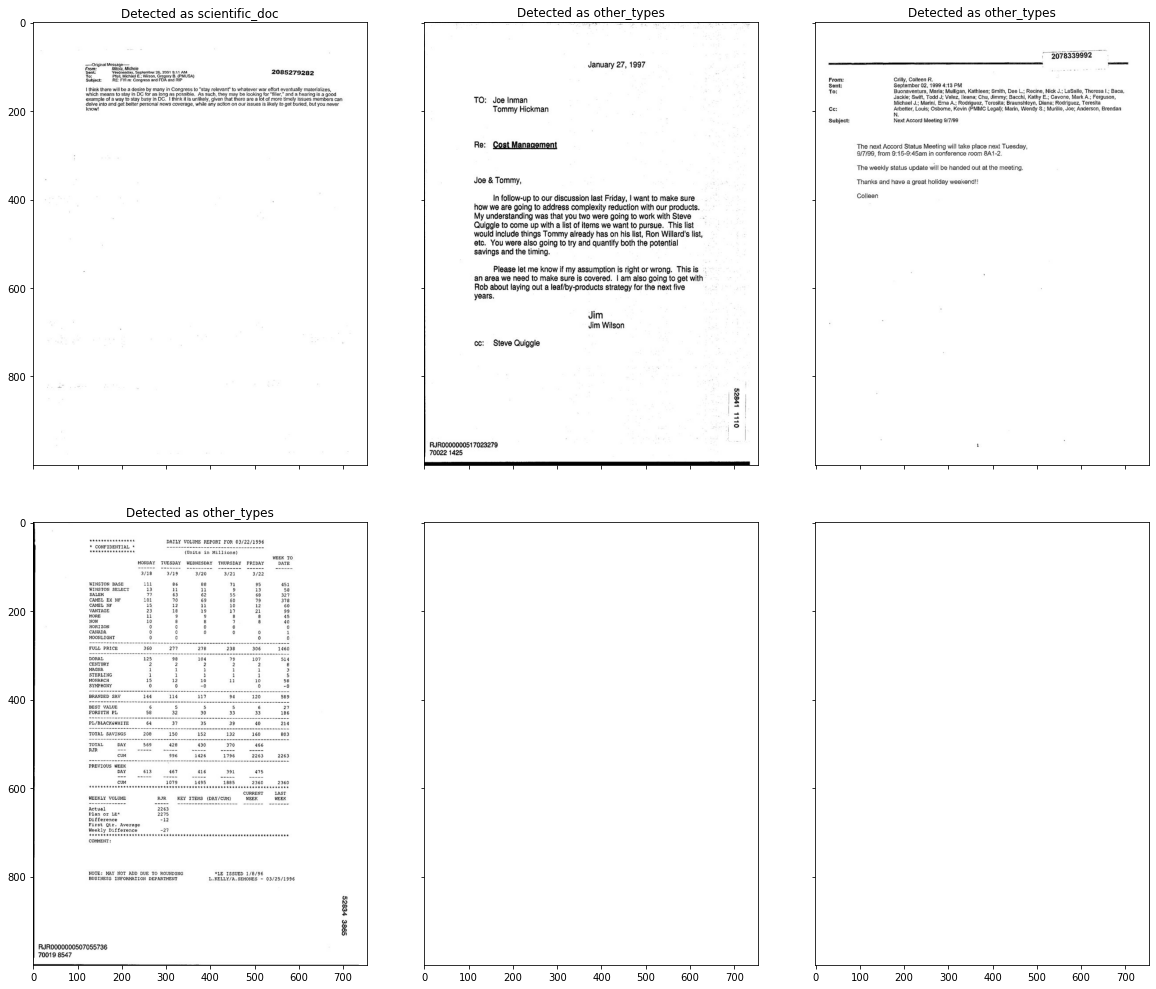

## Wrong predictions for id piece

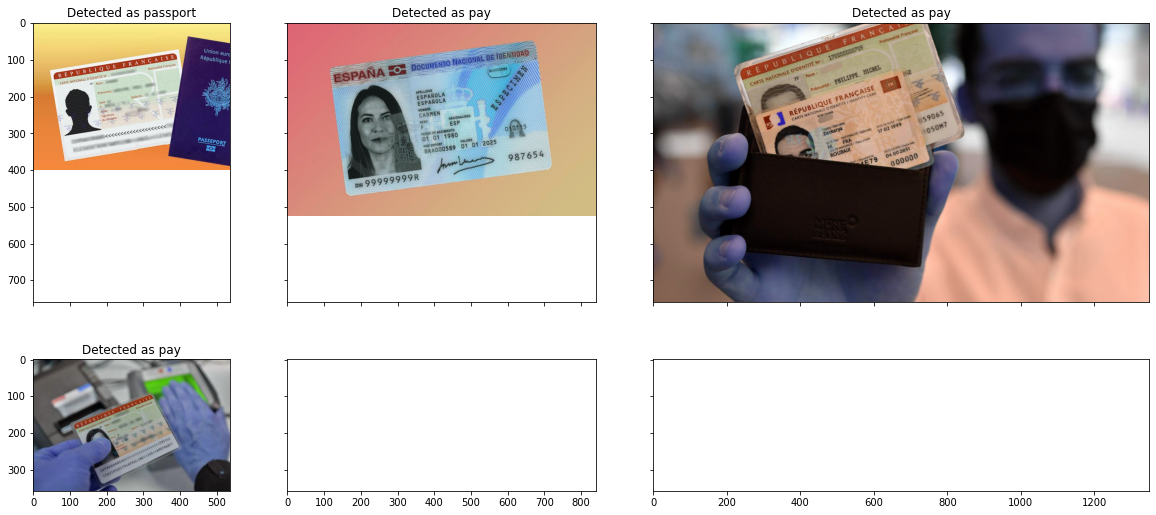

## Wrong predictions for budget

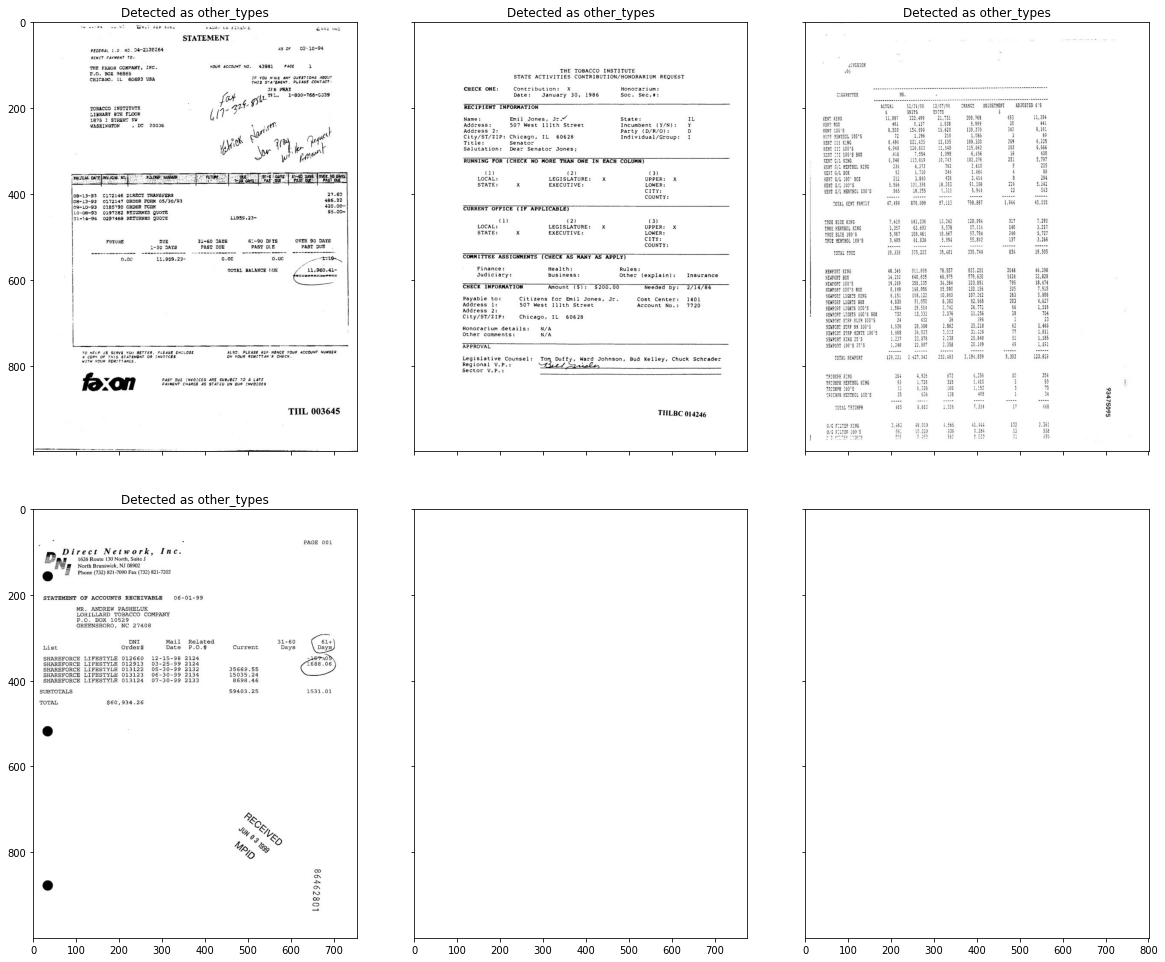

In [20]:
from helpers import read_image, printmd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

def show_wrong_prediction(df,target): 
    fig = plt.figure(figsize=(20., 20.))
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.8,  # pad between axes in inch.
                 aspect = True
                 )
    printmd('## Wrong predictions for ' + df.iloc[0,:][target])
    for ax,(index,row) in zip(grid,df.iterrows()):
        ax.imshow(read_image(row['filename']))
        ax.set_title('Detected as ' + row['pred'])
        ax.grid(False)
    plt.show()  

def show_wrong_predictions(df,y_test,y_pred,target='type'):   
    
    X_result = df.loc[y_test.index,:][['filename', target]].copy()
    X_result['real'] = y_test
    X_result['pred'] = y_pred
    X_bad = X_result[X_result['pred']!=X_result['real']]
    
    fig = plt.figure(figsize=(10,10))
    sns.countplot(y=target,data=X_bad)
    plt.title('Wrong predictions count')
    plt.show()
    
    
    vc = pd.DataFrame(X_bad[target].value_counts()).head(8)
    for t in vc.index.tolist():
        show_wrong_prediction(X_bad[X_bad['target_min']==t],target)
        

show_wrong_predictions(df,y_test,y_pred,target='target_min')